In [1]:
import torch
import torch.nn as nn
import skorch
import numpy as np

from torch.autograd import Variable

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from sine_data import train_dataset, valid_dataset

In [76]:
class Clocking(nn.Module):
    def __init__(self, input_dim, hidden_dim, act='tanh'):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.i2h = nn.Linear(input_dim, hidden_dim)
        self.h2h = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.period = nn.Parameter(torch.randn(hidden_dim) + 1)
        self.shift = nn.Parameter(torch.zeros(hidden_dim))
        self.act = {'relu': nn.ReLU, 'tanh': nn.Tanh}[act]()
        
    def forward(self, x, clock=None, h=None): # x is (b, t, u) 
        if h is None:
            h = torch.zeros(self.hidden_dim)
            h = skorch.utils.to_var(h, x.is_cuda)
            
        ys = []
        cs = []
        for ti in range(x.size(1)):
            clock_gate = (torch.sin(ti/self.period * np.pi + self.shift) + 1) / 2
            # enable stacking of clocking functions
            if clock is not None:
                clock_gate = (clock_gate + clock[ti]) / 2

            h_new = self.i2h(x[:, ti]) + self.h2h(h)
            y = clock_gate * h_new + (1 - clock_gate) * h
            y = self.act(y)
            h = y
            ys.append(y)
            cs.append(clock_gate)
        return torch.stack(ys, dim=1), h, torch.stack(cs, dim=0)

In [77]:
import visdom
vis = visdom.Visdom()

In [78]:
X_train, y_train = train_dataset(points=200)
X_train, y_train = torch.Tensor(X_train), torch.LongTensor(y_train)

X_valid, y_valid = valid_dataset(points=400)
X_valid, y_valid = torch.Tensor(X_valid), torch.LongTensor(y_valid)

sine_train_loader = DataLoader(TensorDataset(X_train, y_train),
                               batch_size=64,
                               shuffle=True)
sine_valid_loader = DataLoader(TensorDataset(X_valid, y_valid),
                               batch_size=64,
                               shuffle=False)

In [79]:
def time_flatten(t):
    return t.view(t.size(0) * t.size(1), -1)

def time_unflatten(t, s):
    return t.view(s[0], s[1], -1)

In [80]:
class ReconModel(nn.Module):
    def __init__(self, num_hidden=64, act='tanh', num_layers=1, inherit_clocks=True):
        super().__init__()
        
        self.rnn = []
        self.num_layers = num_layers
        self.inherit_clocks = inherit_clocks
        
        for i in range(num_layers):
            input_dim = 1 if i == 0 else num_hidden
            self.rnn.append(Clocking(input_dim, num_hidden, act=act))
            self.add_module('rnn'+str(i), self.rnn[-1])
        
        self.clf = nn.Linear(num_hidden, 1)
        
    def forward(self, x):
        li = x
        ci = None
        for i in range(self.num_layers):
            if not self.inherit_clocks:
                ci = None
            li, hi, ci = self.rnn[i](li, clock=ci)
            vis.heatmap(skorch.utils.to_numpy(li[0]), opts={'title': 'act rnn'+str(i)}, win="act rnn"+str(i))
            vis.heatmap(skorch.utils.to_numpy(self.rnn[i].period).reshape(1, -1), opts={'title': 'periods rnn'+str(i)}, win="periods rnn"+str(i))
            vis.heatmap(skorch.utils.to_numpy(self.rnn[i].shift).reshape(1, -1), opts={'title': 'shifts rnn'+str(i)}, win="shifts rnn"+str(i))
            vis.heatmap(skorch.utils.to_numpy(ci), opts={'title': 'clock rnn'+str(i)}, win="clock rnn"+str(i))
        l1 = self.clf(time_flatten(li))
        return time_unflatten(l1, x.size())

In [81]:
class Trainer(skorch.NeuralNet):
    def __init__(
        self, 
        criterion=nn.MSELoss,
        *args, 
        **kwargs
    ):
        super().__init__(*args, criterion=criterion, **kwargs)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        pred = time_flatten(y_pred)
        true = time_flatten(y_true)
        return super().get_loss(pred, true, X=X, training=training)

In [103]:
torch.manual_seed(1337)

def my_train_split(X, y):
    return X, X_valid[:, :-1], y, X_valid[:, 1:]

ef = Trainer(module=ReconModel,
             optimizer=torch.optim.Adam,
             lr=0.02,
             max_epochs=40,
             train_split=my_train_split,
             
             module__num_hidden=16,
             module__act='relu',
             module__num_layers=2,
             module__inherit_clocks=True,
             use_cuda=False,
            )

In [104]:
%pdb on
ef.fit(X_train[:, :-1], X_train[:, 1:])

Automatic pdb calling has been turned ON
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.1887        0.4407  0.5279
      2        0.4304        0.3283  0.5297
      3        0.3455        0.1933  0.5499
      4        0.2023        0.1861  0.5526
      5        0.1989        0.0668  0.5460
      6        0.0878        0.0344  0.5502
      7        0.0704        0.0818  0.6594
      8        0.1228        0.0240  0.5144
      9        0.0512        0.0503  0.5226
     10        0.0676        0.0698  0.5374
     11        0.0841        0.0413  0.5281
     12        0.0544        0.0105  0.5558
     13        0.0256        0.0198  0.5424
     14        0.0374        0.0326  0.5453
     15        0.0493        0.0154  0.5257
     16        0.0283        0.0112  0.6962
     17        0.0202        0.0244  0.5633
     18        0.0306        0.0299  0.5630
     19        0.0355        0.0204  0.5599
     20        0.0267        0.0081

<class '__main__.Trainer'>[initialized](
  module_=ReconModel(
    (rnn0): Clocking(
      (i2h): Linear(in_features=1, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (rnn1): Clocking(
      (i2h): Linear(in_features=16, out_features=16)
      (h2h): Linear(in_features=16, out_features=16)
      (act): ReLU()
    )
    (clf): Linear(in_features=16, out_features=1)
  ),
)

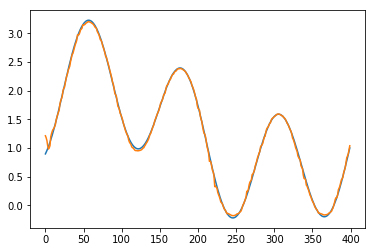

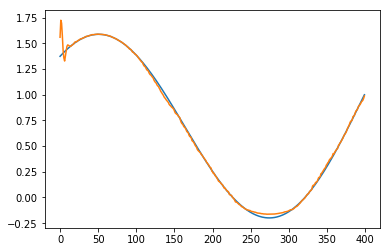

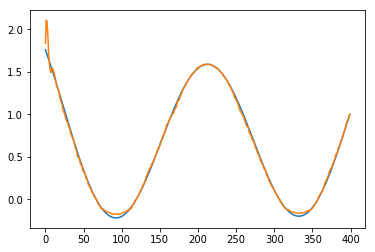

In [105]:
data = X_valid
pred = ef.predict_proba(data)

for i in range(pred.shape[0]):
    plt.figure(i)
    plt.plot(data[i].numpy())
    plt.plot(np.arange(len(pred[i])), pred[i])